In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import math
import scipy
import requests
import warnings
import h5py
import fsspec
from pyproj import Proj, CRS
import pysolid
import pymap3d as pm   #for transformation between ENU and llh

import matplotlib.pyplot as plt

from isce3.core import Ellipsoid as ellips

from osgeo import gdal, osr

import shapely.wkt as wkt
from shapely import geometry

from src.ALE_utils import oversample_slc, findCR
import os
import timeit
warnings.filterwarnings('ignore')

In [2]:
# Start runtime evaluation
start = timeit.default_timer()

In [3]:
# Parameters for papermill
data_dir = 's3://opera-provisional-products/CSLC/pst_adt_common/gamma_v.0.3/Rosamond/Ascending'
save_dir = '/mnt/trappist-r0/bato/work/calval-CSLC/Rosamond/A064_run4'
burst_id = 't064_135523_iw2'
date = '20150207'
snr_threshold = 15
solidtide = 'True'
cr_network = 'Rosamond'

In [4]:
pol = 'VV'
path_h5 = f'{data_dir}/{burst_id}/{date}/{burst_id}_{date}.h5' 
s3f = fsspec.open(path_h5, mode='rb', anon=True, default_fill_cache=False)

# Load the CSLC and necessary metadata
grid_path = f'data'
metadata_path = f'metadata'
burstmetadata_path = f'metadata/processing_information/input_burst_metadata'
id_path = f'identification'

with h5py.File(s3f.open(),'r') as h5:
    cslc = h5[f'{grid_path}/{pol}'][:]
    azimuth_carrier_phase = h5[f'{grid_path}/azimuth_carrier_phase'][:]
    flattening_phase = h5[f'{grid_path}/flattening_phase'][:]
    xcoor = h5[f'{grid_path}/x_coordinates'][:]
    ycoor = h5[f'{grid_path}/y_coordinates'][:]
    dx = h5[f'{grid_path}/x_spacing'][()].astype(int)
    dy = h5[f'{grid_path}/y_spacing'][()].astype(int)
    epsg = h5[f'{grid_path}/projection'][()].astype(int)
    sensing_start = h5[f'{burstmetadata_path}/sensing_start'][()].astype(str)
    sensing_stop = h5[f'{burstmetadata_path}/sensing_stop'][()].astype(str)
    dims = h5[f'{burstmetadata_path}/shape'][:]
    bounding_polygon =h5[f'{id_path}/bounding_polygon'][()].astype(str) 
    orbit_direction = h5[f'{id_path}/orbit_pass_direction'][()].astype(str)
    center_lon, center_lat = h5[f'{burstmetadata_path}/center']
    
# Get bounding box
cslc_poly = wkt.loads(bounding_polygon)

# Deramp the cslc
ramp = np.exp(1j*azimuth_carrier_phase)
cslc = cslc*np.conj(ramp)

# Unflatten the cslc
flat_phase = np.exp(1j*flattening_phase)
cslc = cslc*np.conj(flat_phase) 

In [5]:
# Check if the CR data already exists
if os.path.exists(f'{save_dir}/crdata/crdata_{date}.csv') == False and cr_network=='Rosamond':
    # Get the cslc date
    date_ = dt.datetime.strptime(sensing_start.astype(str),'%Y-%m-%d %H:%M:%S.%f').strftime('%Y-%m-%d+%H\u0021%M')

    # Download corner reflector data from UAVSAR/NISAR based on the date of the CSLC product
    res = requests.get(f'https://uavsar.jpl.nasa.gov/cgi-bin/corner-reflectors.pl?date={str(date_)}&project=uavsar')
    open(f'{save_dir}/crdata/crdata_{date}.csv', 'wb').write(res.content)

elif os.path.exists(f'crdata_{date}.csv') == False and cr_network=='Oklahoma':
    # Get the cslc date
    date_ = dt.datetime.strptime(sensing_start.astype(str),'%Y-%m-%d %H:%M:%S.%f').strftime('%Y-%m-%d+%H\u0021%M')
    
    # Download corner reflector data from UAVSAR/NISAR based on the date of the CSLC product
    res = requests.get(f'https://uavsar.jpl.nasa.gov/cgi-bin/corner-reflectors.pl?date={str(date_)}&project=nisar')
    open(f'{save_dir}/crdata/crdata_{date}.csv', 'wb').write(res.content)

else:
    print(f'Corner Reflector Data: crdata_{date}.csv already exists. Skipping download.')

# Read to pandas dataframe and rename columns
df = pd.read_csv(f'{save_dir}/crdata/crdata_{date}.csv')
df.rename(columns={'Corner reflector ID':'ID'}, inplace=True)
df.rename(columns={'Latitude (deg)':'lat'}, inplace=True) 
df.rename(columns={'Longitude (deg)':'lon'}, inplace=True) 
df.rename(columns={'Azimuth (deg)':'azm'}, inplace=True)
df.rename(columns={'Tilt / Elevation angle (deg)':'tilt'}, inplace=True)
df.rename(columns={'Height above ellipsoid (m)':'hgt'}, inplace=True) 
df.rename(columns={'Side length (m)':'slen'}, inplace=True)
df.slen = np.round(df.slen,1)
df.head()

,ID,lat,lon,hgt,azm,tilt,slen
0,0,34.796968,-118.096527,660.9023,172.0,11.24,2.4
1,1,34.799763,-118.087048,661.0827,170.0,8.39,2.4
2,2,34.805237,-118.087457,660.8839,170.0,9.57,2.4
3,3,34.805342,-118.081907,661.0615,174.0,8.78,2.4
4,4,34.805415,-118.076376,661.1406,174.0,12.48,2.4


In [6]:
if (solidtide == 'True' ):
    #solid earth tide correction with PySolid
    dateformat = '%Y-%m-%d %H:%M:%S.%f'  #date format of input azimuth time
    dt0 = dt.datetime.strptime(sensing_start,dateformat)
    dt1 = dt.datetime.strptime(sensing_stop,dateformat)
    step_sec = 5                        # sample spacing in time domain in seconds

    for idx, row in df.iterrows():

        llh = [np.deg2rad(row['lon']), np.deg2rad(row['lat']), row['hgt']]  #lon/lat/hgt

        _elp = ellips()
        xyz = _elp.lon_lat_to_xyz(llh) #xyz coordinate of CR

        # compute SET via pysolid
        (dt_out,
         tide_e,
         tide_n,
         tide_u) = pysolid.calc_solid_earth_tides_point(np.rad2deg(llh[1]), np.rad2deg(llh[0]), dt0, dt1,
                                                    step_sec=step_sec,
                                                    display=False,
                                                    verbose=False)

        tide_e = np.mean(tide_e[0:2])
        tide_n = np.mean(tide_n[0:2])
        tide_u = np.mean(tide_u[0:2])

        #updating lat,lon,hgt after SET correction
        llh = pm.enu2geodetic(tide_e, tide_n, tide_u,np.rad2deg(llh[1]),np.rad2deg(llh[0]),llh[2],deg=True)

        df.loc[idx,'lat'] = llh[0]
        df.loc[idx,'lon'] = llh[1]
        df.loc[idx,'hgt'] = llh[2]   

PYSOLID: calculate solid Earth tides in east/north/up direction
PYSOLID: lot/lon: 34.79696817/-118.09652683 degree
PYSOLID: start UTC: 2015-02-07T01:50:05.398422
PYSOLID: end   UTC: 2015-02-07T01:50:08.872312
PYSOLID: time step: 5 seconds
PYSOLID: calculate solid Earth tides in east/north/up direction
PYSOLID: lot/lon: 34.79976258/-118.08704822 degree
PYSOLID: start UTC: 2015-02-07T01:50:05.398422
PYSOLID: end   UTC: 2015-02-07T01:50:08.872312
PYSOLID: time step: 5 seconds
PYSOLID: calculate solid Earth tides in east/north/up direction
PYSOLID: lot/lon: 34.80523668/-118.08745726 degree
PYSOLID: start UTC: 2015-02-07T01:50:05.398422
PYSOLID: end   UTC: 2015-02-07T01:50:08.872312
PYSOLID: time step: 5 seconds
PYSOLID: calculate solid Earth tides in east/north/up direction
PYSOLID: lot/lon: 34.80534176/-118.0819074 degree
PYSOLID: start UTC: 2015-02-07T01:50:05.398422
PYSOLID: end   UTC: 2015-02-07T01:50:08.872312
PYSOLID: time step: 5 seconds
PYSOLID: calculate solid Earth tides in east/

In [7]:
if 'lon' not in df.keys():
    raise SystemExit('No CRs found within burst, exit notebook')

In [8]:
#calculating the locations of CRs in SAR image
UTMx = []
UTMy = []
xloc = []
yloc = []
xloc_float = []
yloc_float = []
_in = []

for idx, row in df.iterrows():
    
    _Proj = Proj(CRS.from_epsg(epsg))
    _x, _y = _Proj(row['lon'], row['lat'],inverse=False)     #conversion of lat/lon of CRs to UTM coordinates
    
    #location of CRs in SLC image
    _xloc = int((_x-xcoor[0])/dx)    
    _yloc = int((_y-ycoor[0])/dy)
    
    UTMx.append(_x) 
    UTMy.append(_y)
    xloc.append(_xloc)
    yloc.append(_yloc)
    xloc_float.append((_x-xcoor[0])/dx)
    yloc_float.append((_y-ycoor[0])/dy)
    _in.append(cslc_poly.contains(geometry.Point(row['lon'], row['lat'])))
    
df['UTMx'] = UTMx
df['UTMy'] = UTMy
df['xloc'] = xloc
df['yloc'] = yloc
df['xloc_float'] = xloc_float
df['yloc_float'] = yloc_float
df['inPoly'] = _in

#checking whether CRs are in SLC coverage. Including only CRs within SLC image
df = df[df['inPoly']==True]
df.drop('inPoly', axis=1, inplace=True)
df = df.reset_index(drop=True)
df.head()

,ID,lat,lon,hgt,azm,tilt,slen,UTMx,UTMy,xloc,yloc,xloc_float,yloc_float
0,0,34.796968,-118.096527,660.812871,172.0,11.24,2.4,399691.409229,3.851076e+06,1287,3026,1287.781846,3026.922832
1,1,34.799762,-118.087048,660.993241,170.0,8.39,2.4,400561.890280,3.851376e+06,1461,2996,1461.878056,2996.876007
2,2,34.805237,-118.087458,660.794434,170.0,9.57,2.4,400531.048677,3.851984e+06,1455,2936,1455.709735,2936.127924
3,3,34.805342,-118.081908,660.972019,174.0,8.78,2.4,401038.837220,3.851990e+06,1557,2935,1557.267444,2935.511225
4,4,34.805415,-118.076376,661.051104,174.0,12.48,2.4,401544.916651,3.851993e+06,1658,2935,1658.483330,2935.245362


In [9]:
# selecting CRs according to orbit direction
if orbit_direction == 'Ascending':
    df_filter = df[(df['azm']>140) & (df['azm']<220)].reset_index(drop=True)
    #only west-looking CRs (for right-looking ascending)
else:     #Descending
    df_filter = df[~((df['azm']>140) & (df['azm']<220))].reset_index(drop=True)
    #only east-looking CRs (for right-looking descending)

df_filter = df_filter.loc[df_filter['slen']>0.8].reset_index(drop=True)   #excluding SWOT CRs (0.7 m as a side length)
df = None

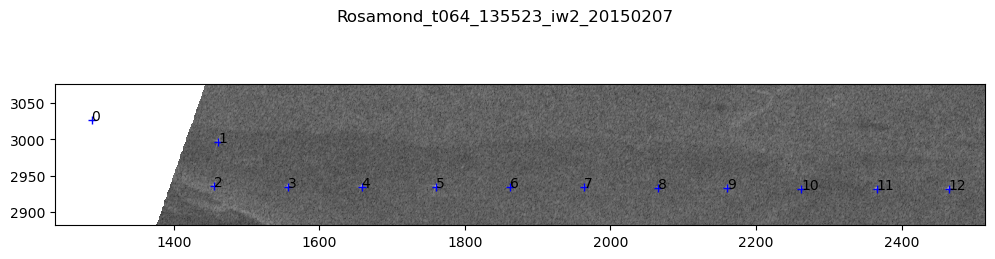

In [10]:
#Displaying SLC image
buffer = 50
minX = df_filter['xloc'].min() - buffer
maxX = df_filter['xloc'].max() + buffer
minY = df_filter['yloc'].min() - buffer
maxY = df_filter['yloc'].max() + buffer

scale_ = 1.0
exp_ = 0.15

fig, ax = plt.subplots(figsize=(12, 3))
cax=ax.imshow(scale_*(np.abs(cslc))**exp_, cmap='gray',interpolation=None, origin='upper')
ax.set_xlim(minX,maxX)
ax.set_ylim(minY,maxY)

for sl in pd.unique(df_filter.slen):
    xx = df_filter.loc[df_filter['slen']==sl]['xloc']
    yy = df_filter.loc[df_filter['slen']==sl]['yloc']
    ID = df_filter.loc[df_filter['slen']==sl]['ID']
    
    if sl == 2.4:
        color='blue'
    elif sl == 4.8:
        color='red'
    elif sl == 2.8:
        color='yellow'
    else:
        color='green'
    
    ax.scatter(xx,yy,color=color,marker="+",lw=1)
    for _ID,_xx,_yy in zip(ID,xx,yy):
        ax.annotate(_ID, (_xx, _yy), fontsize=10)

ax.set_aspect(1)
fig.suptitle(f'{cr_network}_{burst_id}_{date}')
fig.savefig(f'{save_dir}/pngs/S1_CSLC_CRs_{cr_network}_{burst_id}_{date}.png',dpi=300,bbox_inches='tight')

In [11]:
def get_snr_peak(img: np.ndarray, cutoff_percentile: float=3.0):
    '''
    Estimate the signal-to-noise ration (SNR) of the peak
    in the input image patch
    Parameter
    ---------
    img: numpy.ndarray
        SLC image patch to calculate the SNR
    cutout: float
        Cutout ratio of high and low part of the signal to cutoff
    Returns
    -------
    snr_peak_db: float
        SNR of the peak in decibel (db)
    '''

    power_arr = img.real ** 2 + img.imag ** 2

    # build up the mask array
    thres_low = np.nanpercentile(power_arr, cutoff_percentile)
    thres_high = np.nanpercentile(power_arr, 100 - cutoff_percentile)
    mask_threshold = np.logical_and(power_arr < thres_low,
                                    power_arr > thres_high)
    mask_invalid_pixel = np.logical_and(power_arr <= 0.0,
                                        np.isnan(power_arr))
    ma_power_arr = np.ma.masked_array(power_arr,
                                      mask=np.logical_and(mask_threshold,
                                                          mask_invalid_pixel))

    peak_power = np.nanmax(power_arr)
    mean_background_power = np.mean(ma_power_arr)

    snr_peak_db = np.log10(peak_power / mean_background_power) * 10.0

    return snr_peak_db

In [12]:
xpeak = []
ypeak = []
snr = []

for ID, xoff, yoff in zip(df_filter['ID'],df_filter['xloc'],df_filter['yloc']):
    # crop a patch of 10*10 with center at the calculated CR position
    pxbuff = 5
    pybuff = 5
    cropcslc = cslc[(yoff-pybuff):(yoff+pybuff),(xoff-pxbuff):(xoff+pxbuff)]
    _snr = get_snr_peak(cropcslc)

    # fig, ax = plt.subplots(figsize=(9, 6))
    # cax=ax.imshow(20*np.log10(np.abs(cropcslc)), cmap='gray',interpolation=None,
    #               extent=(xoff-pxbuff,xoff+pxbuff+1,yoff+pybuff+1,yoff-pybuff),origin='upper')
    # ax.set_aspect(1)
    # fig.colorbar(cax)

    # find the peak amplitude in the 10*10 patch
    yind,xind = np.unravel_index(np.argmax(np.abs(cropcslc), axis=None), cropcslc.shape)
    
    # give a warning if the peak and the calculated postion are too far
    dyind = yind-pybuff; dxind = xind-pxbuff
    dist = math.sqrt(dyind**2+dxind**2)
    if dist > 5.0:
        warnings.warn(f'the most bright pixel and the xloc is too far for CR {ID}')
    
    # crop a patch of 32*32 but with its center at the peak
    xbuff = 32
    ybuff = 32
    ycrop = np.arange(yoff+dyind-ybuff,yoff+dyind+ybuff)
    xcrop = np.arange(xoff+dxind-xbuff,xoff+dxind+xbuff)
    cropcslc = cslc[ycrop,:][:,xcrop]

    # fig, ax = plt.subplots(figsize=(9, 6))
    # cax=ax.imshow(20*np.log10(np.abs(cropcslc)), cmap='gray',interpolation=None,
    #               extent=(xoff+dxind-xbuff,xoff+dxind+xbuff+1,yoff+dyind+ybuff+1,yoff+dyind-ybuff),origin='upper')
    # fig.colorbar(cax)
    # ax.set_aspect(1)

    # oversample this 32*32 patch by 32
    ovsFactor = 64
    cropcslc_ovs,ycrop_ovs,xcrop_ovs = oversample_slc(cropcslc,sampling=ovsFactor,y=ycrop,x=xcrop)

    # fig, ax = plt.subplots(figsize=(9, 6))
    # cax=ax.imshow(20*np.log10(np.abs(cropcslc_ovs)), cmap='gray',interpolation=None,
    #               extent=(xoff+dxind-xbuff,xoff+dxind+xbuff+1,yoff+dyind+ybuff+1,yoff+dyind-ybuff),origin='upper',vmin=0,vmax=100)
    # fig.colorbar(cax)
    # fig.suptitle(f'CR{ID}')
    # ax.set_aspect(1)

    # find the peak amplitude again in a 2 x 2 patch, it correspond to 
    # (2*ovsFactor) x (2*ovsFactor) in oversampled slc
    yoff2 = int(cropcslc_ovs.shape[0]/2)
    xoff2 = int(cropcslc_ovs.shape[1]/2)
    cropcslc2 = cropcslc_ovs[yoff2-ovsFactor:yoff2+ovsFactor+1,
                           xoff2-ovsFactor:xoff2+ovsFactor+1]
    yind2,xind2 = np.unravel_index(np.argmax(abs(cropcslc2), axis=None), cropcslc2.shape)
    dyind2 = yind2-ovsFactor; dxind2 = xind2-ovsFactor

    # crop a patch of 3x3 oversampled patch with center at the peak
    cropcslc2 = cropcslc_ovs[yoff2+dyind2-1:yoff2+dyind2+2,xoff2+dxind2-1:xoff2+dxind2+2]
    ycrop2 = ycrop_ovs[yoff2+dyind2-1:yoff2+dyind2+2]
    xcrop2 = xcrop_ovs[xoff2+dxind2-1:xoff2+dxind2+2]
    xxcrop2,yycrop2 = np.meshgrid(xcrop2,ycrop2)
    xxcrop2_f = xxcrop2.flatten()
    yycrop2_f = yycrop2.flatten()
    cropcslc2_f = cropcslc2.flatten()

    # fig, ax = plt.subplots(figsize=(9, 6))
    # cax=ax.imshow(20*np.log10(np.abs(cropcslc2)), cmap='gray',interpolation=None,
    #               extent=[xcrop2[0],xcrop2[-1],ycrop2[-1],ycrop2[0]],origin='upper')
    # ax.set_aspect(1)
    # fig.suptitle(f'CR{ID}')
    # fig.colorbar(cax)

    # Check if pixel values in a patch are non-NaN
    valid = ~(np.isnan(cropcslc2_f))
    count_valid = np.count_nonzero(valid)

    if count_valid == 0:
        _ypeak, _xpeak = [np.nan, np.nan]

    else:
        _ypeak,_xpeak = findCR(np.abs(cropcslc2_f[valid]),yycrop2_f[valid],xxcrop2_f[valid],
                            x_bound=[xcrop2[0],xcrop2[-1]],y_bound=[ycrop2[0],ycrop2[-1]],method="para")

    xpeak.append(_xpeak)
    ypeak.append(_ypeak)
    snr.append(_snr)
    
df_filter['xloc_CR'] = xpeak
df_filter['yloc_CR'] = ypeak
df_filter['snr'] = snr
df_filter

,ID,lat,lon,hgt,azm,tilt,slen,UTMx,UTMy,xloc,yloc,xloc_float,yloc_float,xloc_CR,yloc_CR,snr
0,0,34.796968,-118.096527,660.812871,172.00,11.24,2.4,399691.409229,3.851076e+06,1287,3026,1287.781846,3026.922832,NaN,NaN,NaN
1,1,34.799762,-118.087048,660.993241,170.00,8.39,2.4,400561.890280,3.851376e+06,1461,2996,1461.878056,2996.876007,1461.690280,2997.062500,14.938538
2,2,34.805237,-118.087458,660.794434,170.00,9.57,2.4,400531.048677,3.851984e+06,1455,2936,1455.709735,2936.127924,1455.351643,2936.254942,14.979407
3,3,34.805342,-118.081908,660.972019,174.00,8.78,2.4,401038.837220,3.851990e+06,1557,2935,1557.267444,2935.511225,1556.958701,2935.479796,15.077111
4,4,34.805415,-118.076376,661.051104,174.00,12.48,2.4,401544.916651,3.851993e+06,1658,2935,1658.483330,2935.245362,1658.286808,2935.279780,15.111912
5,5,34.805493,-118.070801,661.140688,173.17,9.09,2.4,402054.947199,3.851996e+06,1760,2934,1760.489440,2934.922810,1760.193833,2934.906250,15.613286
6,6,34.805584,-118.065224,661.153173,171.36,10.91,2.4,402565.225679,3.852000e+06,1862,2934,1862.545136,2934.455833,1862.394430,2934.558422,14.634985
7,7,34.805669,-118.059665,661.222458,173.60,11.70,2.4,403073.823667,3.852005e+06,1964,2934,1964.264733,2934.049909,1963.918338,2934.199567,15.314733
8,8,34.805751,-118.054071,661.367243,172.83,9.84,2.4,403585.584488,3.852008e+06,2066,2933,2066.616898,2933.677654,2066.473376,2933.926748,14.528525
9,9,34.805813,-118.048913,661.361229,175.12,10.24,2.4,404057.456256,3.852010e+06,2160,2933,2160.991251,2933.483580,2160.629416,2933.557775,14.831741


In [13]:
df_filter = df_filter.dropna()
df_filter = df_filter[df_filter.snr > snr_threshold]
df_filter

,ID,lat,lon,hgt,azm,tilt,slen,UTMx,UTMy,xloc,yloc,xloc_float,yloc_float,xloc_CR,yloc_CR,snr
3,3,34.805342,-118.081908,660.972019,174.00,8.78,2.4,401038.837220,3.851990e+06,1557,2935,1557.267444,2935.511225,1556.958701,2935.479796,15.077111
4,4,34.805415,-118.076376,661.051104,174.00,12.48,2.4,401544.916651,3.851993e+06,1658,2935,1658.483330,2935.245362,1658.286808,2935.279780,15.111912
5,5,34.805493,-118.070801,661.140688,173.17,9.09,2.4,402054.947199,3.851996e+06,1760,2934,1760.489440,2934.922810,1760.193833,2934.906250,15.613286
7,7,34.805669,-118.059665,661.222458,173.60,11.70,2.4,403073.823667,3.852005e+06,1964,2934,1964.264733,2934.049909,1963.918338,2934.199567,15.314733
12,12,34.806046,-118.032280,661.814683,172.37,11.73,2.4,405579.252606,3.852020e+06,2465,2932,2465.350521,2932.478800,2465.005362,2932.571524,15.348622


In [14]:
#absloute geolocation error in range and azimuth after corrections
ALE_Rg = (df_filter['xloc_CR'] -  df_filter['xloc_float'])*dx
ALE_Az = (df_filter['yloc_CR'] - df_filter['yloc_float'])*np.abs(dy)

# Add to the dataframe
df_filter.loc[:,"ALE_Rg"] = ALE_Rg
df_filter.loc[:,"ALE_Az"] = ALE_Az
df_filter.head()

,ID,lat,lon,hgt,azm,tilt,slen,UTMx,UTMy,xloc,yloc,xloc_float,yloc_float,xloc_CR,yloc_CR,snr,ALE_Rg,ALE_Az
3,3,34.805342,-118.081908,660.972019,174.00,8.78,2.4,401038.837220,3.851990e+06,1557,2935,1557.267444,2935.511225,1556.958701,2935.479796,15.077111,-1.543716,-0.314288
4,4,34.805415,-118.076376,661.051104,174.00,12.48,2.4,401544.916651,3.851993e+06,1658,2935,1658.483330,2935.245362,1658.286808,2935.279780,15.111912,-0.982611,0.344178
5,5,34.805493,-118.070801,661.140688,173.17,9.09,2.4,402054.947199,3.851996e+06,1760,2934,1760.489440,2934.922810,1760.193833,2934.906250,15.613286,-1.478036,-0.165597
7,7,34.805669,-118.059665,661.222458,173.60,11.70,2.4,403073.823667,3.852005e+06,1964,2934,1964.264733,2934.049909,1963.918338,2934.199567,15.314733,-1.731978,1.496583
12,12,34.806046,-118.032280,661.814683,172.37,11.73,2.4,405579.252606,3.852020e+06,2465,2932,2465.350521,2932.478800,2465.005362,2932.571524,15.348622,-1.725796,0.927245


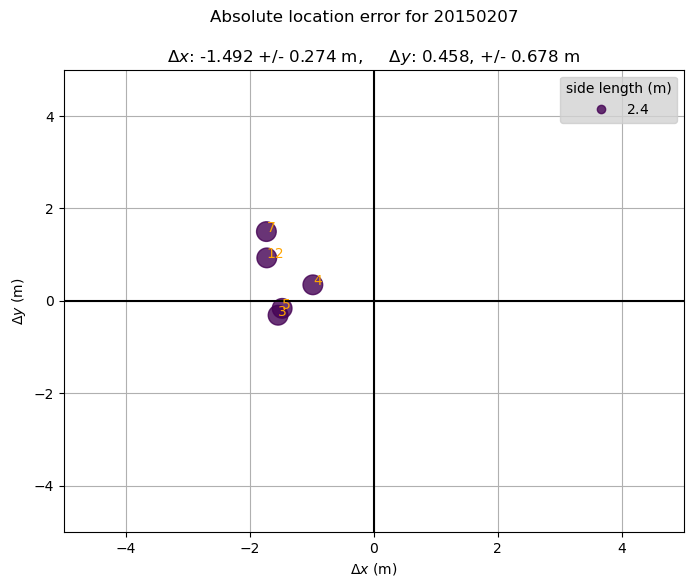

In [15]:
#plotting ALE
fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(df_filter.ALE_Rg, df_filter.ALE_Az, s=200, c=df_filter['slen'], alpha=0.8, marker='o')
ax.legend(*sc.legend_elements(),facecolor='lightgray')
ax.get_legend().set_title('side length (m)')
for ii, txt in enumerate(df_filter.ID):
    ax.annotate(txt, (df_filter[df_filter['ID']==txt].ALE_Rg, df_filter[df_filter['ID']==txt].ALE_Az), color='orange')   #putting IDs in each CR
ax.grid(True)
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.axhline(0, color='black')
ax.axvline(0, color='black')
ax.set_title(f'$\Delta x$: {np.round(np.nanmean(ALE_Rg), 3)} +/- {np.round(np.nanstd(ALE_Rg),3)} m, \
    $\Delta y$: {np.round(np.nanmean(ALE_Az),3)}, +/- {np.round(np.nanstd(ALE_Az),3)} m')
ax.set_xlabel('$\Delta x$ (m)')
ax.set_ylabel('$\Delta y$ (m)')
fig.suptitle(f'Absolute location error for {date}')
fig.savefig(f'{save_dir}/pngs/ALE_{cr_network}_{burst_id}_{date}.png',dpi=300,bbox_inches='tight')

In [16]:
# Save the summary
ALE_Rg_Mean = np.round(np.nanmean(ALE_Rg),3)
ALE_Az_Mean = np.round(np.nanmean(ALE_Az),3)
ALE_Rg_Stdev = np.round(np.nanstd(ALE_Rg),3)
ALE_Az_Stdev = np.round(np.nanstd(ALE_Az),3)

summary = []
summary.append([date, ALE_Rg_Mean, ALE_Rg_Stdev, ALE_Az_Mean, ALE_Az_Stdev])
summary_df = pd.DataFrame(summary)
summary_df.to_csv(f'{save_dir}/summary/ALE_{cr_network}.csv', mode='a', header=False)

summary = []
for ID, ALE_Rg_, ALE_Az_ in zip(df_filter['ID'],ALE_Rg,ALE_Az):
    summary.append([date, ID, ALE_Rg_, ALE_Az_])
summary_df = pd.DataFrame(summary)
summary_df.to_csv(f'{save_dir}/summary/ALE_{cr_network}_ID.csv', mode='a', header=False)

In [17]:
# End runtime evaluation
stop = timeit.default_timer()
print(f'Time: ', (stop - start)/60, 'min.')

Time:  2.290481700996558 min.
